# Deploy Secludy AI Model Model Package from AWS Marketplace 



This sample notebook shows you how to deploy [Secludy](https://www.secludy.com/) [algorithm](https://docs.aws.amazon.com/marketplace/latest/buyerguide/product-types-machine-learning-products.html#algorithm-overview) using Amazon SageMaker as [batch transform jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html). A batch transform job is a finite execution designed for bulk inference of records in a dataset that writes predictions to a file.  The following figure illustrates the workflow for deploying a model package for inference.

# 1 Prerequisites

You need the following prerequisites to properly run this notebook.  For help with any of the prerequisites, please visit the Secludy AWS Marketplace model algorithms <font color='red'>[public documentation insert link here]</font>


1. You have subscribed to <font color='red'>[Secludy model algorithms need to insert link here]</font> you want to deploy.
2. You have sufficient quota for the number and type of SageMaker instances you want to deploy your model packages on — for your desired region and deployment type (i.e. real-time inferencing endpoint or batch job).

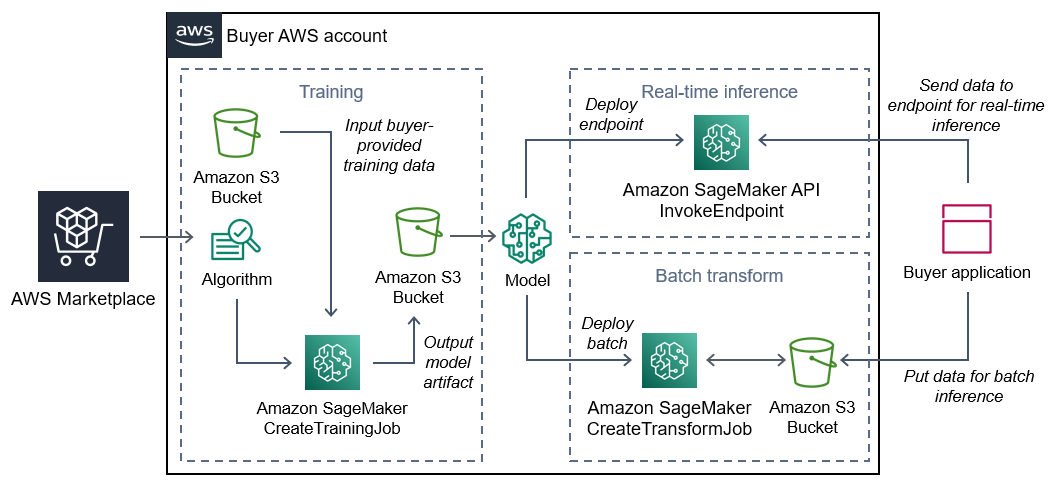

## 2.1 User Configuration

Set the ID of the model you want to deploy.

In [ ]:
# Set model ID to one of the following:
# "secludy-general-1", "secludy-healthcare-1",
# "secludy-law-1", "secludy-finance-1", "secludy-multilingual-1", 
MODEL_ID = "secludy-general-1"

Set the instance type you want to deploy on for the respective deployment type.  Be sure to check that the specified instance is supported for your model and deployment type.  You can do this by looking at the specific listing page for your model in the <font color='red'> [AWS Marketplace linker to seller information page] </font>

In [3]:
# P4d instances are Nvidia A100 GPUs. 
ENDPOINT_INSTANCE = "ml.p4d.24xlarge"
BATCH_INSTANCE = "ml.p4d.24xlarge"

## 2.2 Helper Functions

In [ ]:
# Checks if a model (specified by a model ID) is an embedding model
def model_is_synthetic(model_id):
    secludy_models =  ["secludy-general-1"]
    return (model_id in secludy_models)

This section introduces helper functions for the notebook to support multiple models and abstract away AWS-specific identifiers.  Users should not need to modify any of these functions.  Secludy will publish an updated notebook if values need to be updated.

Like any AWS resource, model packages are uniquely identified by [Amazon Resource Names](https://docs.aws.amazon.com/IAM/latest/UserGuide/reference-arns.html) (ARN).  Specifically, we'll be identifying model packages with the following ARN format: `arn:partition:service:region:account-id:resource-type/resource-id`.

For example: `arn:aws:sagemaker:us-east-1:865070037744:model-package/secludy-general-1-9d8b876c9ef63b0e811b51f60a450e57` <font color='red'>[need to update this]</font>

We separate the model algo ARN into a prefix and its resource identifier (`resource-id`) and store them in the `arn_region_prefix` and `model_arn_resource_id` dictionaries, respectively.  A helper function is provided to return the proper model package ARN given a model ID and region.

You can always directly find the model package ARN for your subscribed model by looking at the specific listing configuration page for the model in the <font color='red'> [AWS Marketplace linker to seller information page] </font>  If you would like more detail, please visit the Secludy AWS Marketplace model algorithm <font color='red'>[public documentation insert link here]</font>

In [ ]:
model_arn_resource_id = {
    #"voyage-2": "voyage-2-61d99cdc29f7359e9f70b9a6098826ae",
    #"voyage-large-2": "voyage-large-2-0ff46a42571f34ffbc8182db4cfca13d",
   # "voyage-large-2-instruct": "voyage-large-2-instruct-7557d7ff5d183919a4e767c35eb8b0f3",
   # "voyage-code-2": "voyage-code-2-b220a35876c038039869f51e600d44b4",
   # "voyage-law-2": "voyage-law-2-9eed475b45ec3034bee6cb155fdd853d",
    #"voyage-finance-2": "voyage-finance-2-1adbefe1db413d249a1e44270d748140",
    #"voyage-multilingual-2": "voyage-multilingual-2-9d8b876c9ef63b0e811b51f60a450e57",
    #"rerank-lite-1": "rerank-lite-1-3a1cfa7773203a7d8c50b27fd9ecadc1"
}

In [ ]:
 arn_region_prefix = {
#     "us-east-1": "arn:aws:sagemaker:us-east-1:865070037744:model-package/",
#     "us-east-2": "arn:aws:sagemaker:us-east-2:057799348421:model-package/",
#     "us-west-1": "arn:aws:sagemaker:us-west-1:382657785993:model-package/",
#     "us-west-2": "arn:aws:sagemaker:us-west-2:594846645681:model-package/",
#     "ca-central-1": "arn:aws:sagemaker:ca-central-1:470592106596:model-package/",
#     "eu-central-1": "arn:aws:sagemaker:eu-central-1:446921602837:model-package/",
#     "eu-west-1": "arn:aws:sagemaker:eu-west-1:985815980388:model-package/",
#     "eu-west-2": "arn:aws:sagemaker:eu-west-2:856760150666:model-package/",
#     "eu-west-3": "arn:aws:sagemaker:eu-west-3:843114510376:model-package/",
#     "eu-north-1": "arn:aws:sagemaker:eu-north-1:136758871317:model-package/",
#     "ap-southeast-1": "arn:aws:sagemaker:ap-southeast-1:192199979996:model-package/",
#     "ap-southeast-2": "arn:aws:sagemaker:ap-southeast-2:666831318237:model-package/",
#     "ap-northeast-2": "arn:aws:sagemaker:ap-northeast-2:745090734665:model-package/",
#     "ap-northeast-1": "arn:aws:sagemaker:ap-northeast-1:977537786026:model-package/",
#     "ap-south-1": "arn:aws:sagemaker:ap-south-1:077584701553:model-package/",
#     "sa-east-1": "arn:aws:sagemaker:sa-east-1:270155090741:model-package/"
 }

In [4]:
# Returns the model package ARN given a model ID and region
def get_model_package_arn(model_id, region):
    return arn_region_prefix[region] + model_arn_resource_id[model_id]

## 2.3 Initialize SageMaker runtime client

Install, upgrade, and import the AWS SDK for Python ([Boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)).

In [8]:
!pip install boto3 --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.1/389.1 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 4.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 4.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.0/148.0 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.0 MB/s eta 0:00:00
   ━

In [6]:
import boto3

Import required packages.

In [9]:
import json
import sagemaker as sage
from sagemaker import get_execution_role, ModelPackage
import time
import pprint
pp2 = pprint.PrettyPrinter(indent=2, width=80, compact=True, depth=2)
pp3 = pprint.PrettyPrinter(indent=2, width=80, compact=True, depth=3)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/ming/Library/Application Support/sagemaker/config.yaml


Determine the current AWS region of the boto3 session.

In [ ]:
current_region = boto3.Session().region_name
print("Current AWS Region: " + current_region)

# Validate if the current region is supported
if current_region not in arn_region_prefix:
    raise Exception(f"The region {current_region} of the current boto3 session is not supported.")

In [ ]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket = sagemaker_session.default_bucket()
runtime = boto3.client("runtime.sagemaker")
bucket

Initialize the SageMaker runtime.

In [ ]:
session = sage.Session()
role = get_execution_role()
sm_runtime = boto3.client("sagemaker-runtime")

## 2.4 Initialize model

Retrieve the model package [Amazon Resource Name](https://docs.aws.amazon.com/IAM/latest/UserGuide/reference-arns.html) (ARN) for your model in the current region.

In [ ]:
model_package_arn = get_model_package_arn(MODEL_ID, current_region)
print("Model package ARN: " + model_package_arn)

Create a model instance.

In [ ]:
model = ModelPackage(
    role=role,
    model_package_arn=model_package_arn,
    sagemaker_session=session,
)

## 3.1 Set up a batch transform job

Use default S3 bucket for input and output data.

In [ ]:
s3_bucket = session.default_bucket()
print("Default SageMaker Session Bucket: " + s3_bucket)

Initialize S3 client.

In [ ]:
s3_client = session.boto_session.client("s3")

## 3.2 Create and store example data

Define batch transform job input file name.

In [ ]:
INPUT_FILE_NAME = "batch-input.jsonl"

Create an example input file using our example documents dataset above.  Each line in the example input file contains a single document from our dataset and a batch transform request ID (`id`).  If specified, the batch transform request ID (`id`) value will be part of the output prediction record, matching it with the corresponding input data record.  

Example input record:
`{"id": "0", "input": "The future of quantum computing in cryptographic applications."}`

Example output prediction record:
????????????

In [ ]:
with open(INPUT_FILE_NAME, "w") as f:
    for index, doc in enumerate(documents):
        json_line = json.dumps({"id": str(index), "input": doc})
        f.write(json_line + "\n")
print("Created example data in " + INPUT_FILE_NAME)

Define input and output S3 paths.

In [15]:
batch_input_path = f"s3://{s3_bucket}/batch_transform_synthetic_data/input/"
batch_output_path = f"s3://{s3_bucket}/batch_transform_synthetic_data/output/"

NameError: name 's3_bucket' is not defined

Put example input file to S3.

In [16]:
with open(INPUT_FILE_NAME, "r") as f:
    file_content = f.read()
    s3_client.put_object(Bucket=s3_bucket, Key="batch_transform_synthetic_data/input/"+INPUT_FILE_NAME, Body=file_content)

FileNotFoundError: [Errno 2] No such file or directory: 'batch-input.jsonl'

## 3.3 Initialize batch transformer

In [ ]:
transformer = model.transformer(
            instance_count=1,
            instance_type=BATCH_INSTANCE,
            output_path=batch_output_path,
            strategy="SingleRecord" #??????????????/
        )

## 3.4 Run job (which can take hours depends on your sample size)

Note, that this example batch transform job is known to take hours because it is using the provided example generated data.  More generally, the duration of the batch transform job will depend on the size of the input dataset to inference.

In [ ]:
if (model_is_synthetic(MODEL_ID)):
    print("Deploying a " + MODEL_ID + " batch transform job on " + BATCH_INSTANCE + ".  Output will be at " + batch_output_path + ".")
    start_time_batch = time.time()
    transformer.transform(
        data=batch_input_path,
        content_type="application/jsonlines",
        split_type="Line",
        wait=True,
        logs=False, # Whether to show the logs produced by the job. Setting to False.
    )
    end_time_batch = time.time()
    elapsed_time_batch = end_time_batch - start_time_batch
    print("\nSuccessfully completed " + MODEL_ID + " batch transform job on " + BATCH_INSTANCE + " in " + str(elapsed_time_batch) + " seconds.")